# Custom Landscape: São Tomé

In this example we will go through setting up a realistic landscape with an externally-generated migration matrix. The migration pattern we will use was created by [Tomás León](https://tomasleon.com/), using a land-used based migration model of mosquitos in the island of São Tomé. 

In [81]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
from os import path
import numpy as np
import pandas as pd
import MGSurvE as srv
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from numpy.random import uniform
from sklearn.preprocessing import normalize
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('customLanscape', './out/')
(ptsPath, migPath) = (
    path.join('../../data/', 'STP_LatLon.csv'),
    path.join('../../data/', 'STP_Migration.csv')
)
srv.makeFolder(OUT_PTH)

## Generating Landscape

After setting our paths up, we start by loading the migration matrix and the latitude and longitude coordinates. It is important to note that MGSurvE will search for either `lon` and `lat`, or `x` and `y` to determine the topology of the landscape:

In [82]:
SAO_TOME_LL = pd.read_csv(ptsPath)
SAO_TOME_MIG = np.genfromtxt(migPath, delimiter=',')
# Row-normalize migration matrix ----------------------------------------------
SAO_TOME_MIG = normalize(SAO_TOME_MIG, axis=1, norm='l1')


Additionally, we calculate the landscape's centroid and bounding box for plotting purposes (not strictly necessary as MGSurvE calculates the tightest bounding box possible, but providing one helps for aesthetics purposes):

In [83]:
# Calculate centrer and bounding box ------------------------------------------
SAO_bbox = (
    (min(SAO_TOME_LL['lon']), max(SAO_TOME_LL['lon'])),
    (min(SAO_TOME_LL['lat']), max(SAO_TOME_LL['lat']))
)
SAO_cntr = [i[0]+(i[1]-i[0])/2 for i in SAO_bbox]
SAO_LIMITS = (
    (SAO_bbox[0][0]-0.05, SAO_bbox[0][1]+0.05), 
    (SAO_bbox[1][0]-0.05, SAO_bbox[1][1]+0.05)
)

With this information at hand we can generate and plot our landscape object:

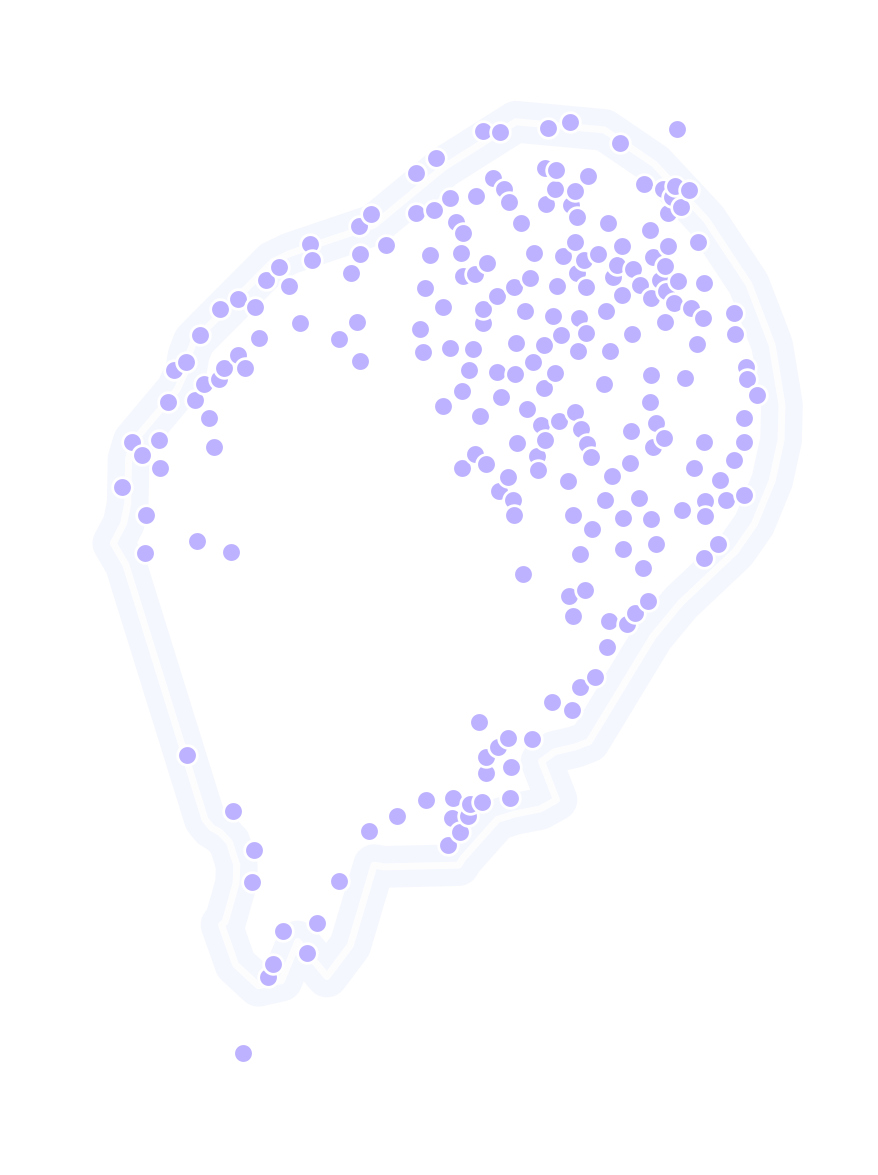

In [84]:
# Land creation ---------------------------------------------------------------
lnd = srv.Landscape(
    SAO_TOME_LL, 
    migrationMatrix=SAO_TOME_MIG,
    landLimits=SAO_LIMITS,
)
# Plots -----------------------------------------------------------------------
bbox = lnd.getBoundingBox()
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=200)
lnd.plotLandBoundary(fig, ax)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    os.path.join(OUT_PTH, '{}.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

To export our generated landscape to disk, we can simply call one of our helper functions:

In [85]:
srv.dumpLandscape(lnd, OUT_PTH, '{}_LND'.format(ID), fExt='pkl')

To re-load it for mode analyisis down the line, we can call:

In [86]:
lnd = srv.loadLandscape(OUT_PTH, '{}_LND'.format(ID), fExt='pkl')

## Optimization

To make this more interesting let's setup ten traps and discrete-optimize them over our geography:

In [87]:
TRPS_NUM = 10
# Defining Traps --------------------------------------------------------------
(initTyp, initFxd, initLon, initLat) = (
    [0]*TRPS_NUM, [False]*TRPS_NUM,
    uniform(*SAO_bbox[0], TRPS_NUM), uniform(*SAO_bbox[1], TRPS_NUM)
)
sid = [0]*(TRPS_NUM) 
traps = pd.DataFrame({
    'sid': sid,
    'lon': initLon, 'lat': initLat, 
    't': initTyp, 'f': initFxd
})
tKer = {0: {'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}
# Updating Landscape ----------------------------------------------------------
lnd.updateTraps(traps=traps, trapsKernels=tKer)
lnd.trapsSiteID = traps['sid']

Optimizing this map reliably requires more than 1500 generations but just to get a taste of the workflow let's set it up to 25 for demonstration purposes. Additionally, we will modify some of the GA parameters (these will be further explained in the [GA Basics demo](../optimization/ga.ipynb)):

In [88]:
(GENS, POP_SIZE, VERBOSE) = (
    25, 
    int(10*(lnd.trapsNumber*1.5)), 
    True
)
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)

We are now ready to setup and run our optimization!

In [89]:
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lnd, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    optimFunction=srv.getDaysTillTrappedPseudoInverse,
    fitFuns={'inner': np.sum, 'outer': np.mean}
)

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min       	avg        	max        	std        	best	traps                                           
0  	150   	2.5766e+13	3.45959e+14	7.78043e+15	6.21408e+14	107 	[83, 123, 237, 67, 116, 212, 169, 120, 174, 121]
1  	93    	1.84057e+13	2.66344e+14	9.46021e+14	9.74778e+13	105 	[118, 3, 9, 157, 111, 9, 224, 200, 100, 212]    
2  	89    	1.8351e+13 	2.18434e+14	3.17341e+14	1.04002e+14	12  	[75, 12, 83, 75, 219, 212, 180, 196, 106, 219]  
3  	86    	1209.9     	1.72027e+14	6.28619e+14	1.29055e+14	1   	[24, 122, 180, 29, 104, 212, 25, 209, 6, 217]   
4  	92    	1209.9     	1.57355e+14	2.1705e+15 	2.12241e+14	14  	[24, 122, 180, 29, 104, 212, 25, 209, 6, 217]   
5  	91    	1132.51    	1.04615e+14	6.97833e+14	1.31573e+14	131 	[84, 113, 179, 158, 104, 212, 25, 60, 24, 183]  
6  	81    	1132.51    	2.10285e+14	2.08868e+16	1.69747e+15	1   	[84, 113, 179, 158, 104, 212, 25, 60, 24, 183]  
7  	78    	1115.84    	7.23719e+13	1.07743e+15	1.33721e+14	33  	[24, 113, 179, 158, 104, 212, 25, 

And let's plot our results!

(<Figure size 1500x1500 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2c3dabee0>)

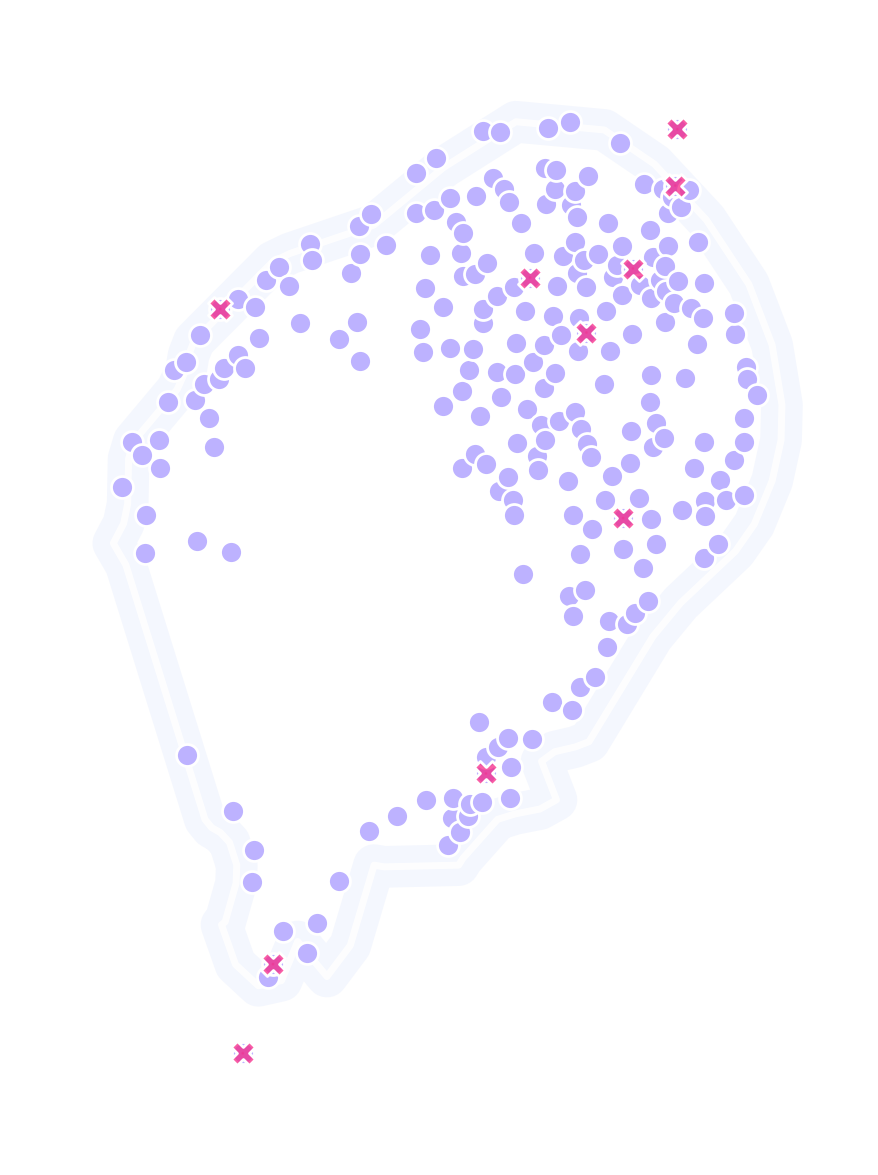

In [90]:
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=250)
# lnd.plotMigrationNetwork(
#     fig, ax, 
#     lineWidth=30, alphaMin=.25, alphaAmplitude=2.5
# )
lnd.plotTraps(
    fig, ax, 
    size=300, transparencyHex='BB', 
    zorders=(30, 25), proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
lnd.plotLandBoundary(fig, ax)

<hr>

# More Information

* [Quickstart](https://chipdelmal.github.io/MGSurvE/build/html/Quickstart.html)
* [Landscape Creation](https://chipdelmal.github.io/MGSurvE/build/html/landscapeCreation.html)
* Doc's Examples: [creation](https://chipdelmal.github.io/MGSurvE/build/html/landscapeCreation.html), [update](https://chipdelmal.github.io/MGSurvE/build/html/landscapeUpdate.html)
* [GA Basics](https://github.com/Chipdelmal/MGSurvE_Webinar2023/blob/main/demos/optimization/ga.ipynb)